# Brain Tumor Detection with Xception

Notebook phan loai u nao su dung mo hinh Xception voi Transfer Learning.

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU available: {len(tf.config.list_physical_devices("GPU")) > 0}')



2026-01-04 03:24:52.289931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767497092.452286      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767497092.500614      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767497092.865855      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767497092.865904      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767497092.865907      24 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU available: True


## 2. Data Preprocessing

### 2.1 Load Data

In [2]:
# Duong dan den du lieu
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Tao DataFrame tu cac thu muc
def create_dataframe(data_dir):
    filepaths, labels = [], []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                filepaths.append(os.path.join(class_path, img_name))
                labels.append(class_name)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

print(f'Training samples: {len(train_df)}')
print(f'Testing samples: {len(test_df)}')
print(f'\nClasses: {train_df["label"].unique()}')

Training samples: 5712
Testing samples: 1311

Classes: ['pituitary' 'notumor' 'meningioma' 'glioma']


### 2.2 Chia Train/Valid/Test

In [3]:
# Chia test_df thanh valid va test
valid_df, test_df = train_test_split(
    test_df, 
    train_size=0.5, 
    random_state=42, 
    stratify=test_df['label']
)

print(f'Train: {len(train_df)}')
print(f'Valid: {len(valid_df)}')
print(f'Test: {len(test_df)}')

Train: 5712
Valid: 655
Test: 656


## Tien xu ly du lieu

In [6]:
import cv2
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

def resize_with_padding(image, target_size=(299, 299)):
    """Resize anh ma KHONG bi meo (them vien den)"""
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized = cv2.resize(image, (new_w, new_h))
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

def preprocess_image(image):
    """CLAHE enhancement + normalize to [-1, 1]"""
    gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    
    return enhanced.astype(np.float32) / 127.5 - 1.0

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, img_size=(299, 299), 
                 augment=False, shuffle=True, class_names=None):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.class_names = class_names or sorted(dataframe['label'].unique())
        self.n_classes = len(self.class_names)
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[batch_indexes]
        X = np.zeros((len(batch_data), *self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_data), self.n_classes), dtype=np.float32)
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            # 1. Load anh
            img = cv2.imread(row['filepath'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # 2. Resize giu ty le
            img = resize_with_padding(img, self.img_size)
            # 3. Augmentation (chi khi training)
            if self.augment:
                img = self._augment(img)
            
            # 4. CLAHE + Normalize
            X[i] = preprocess_image(img)
            # 5. One-hot label
            label_idx = self.class_names.index(row['label'])
            y[i, label_idx] = 1.0
        return X, y
    
    def _augment(self, img):
        # Lat ngang
        if np.random.random() > 0.5:
            img = cv2.flip(img, 1)
        # Xoay ngau nhien
        angle = np.random.uniform(-15, 15)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h), borderValue=0)
        # Thay doi do sang
        factor = np.random.uniform(0.9, 1.1)
        img = np.clip(img * factor, 0, 255).astype(np.uint8)
        return img
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

### 2.4 Data Generators

In [7]:
class_names = sorted(train_df['label'].unique())

train_generator = CustomDataGenerator(
    train_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=True, 
    shuffle=True, 
    class_names=class_names
)

valid_generator = CustomDataGenerator(
    valid_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=False, 
    shuffle=False, 
    class_names=class_names
)

test_generator = CustomDataGenerator(
    test_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=False, 
    shuffle=False, 
    class_names=class_names
)

print(f'Classes: {class_names}')

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## 3. Building Deep Learning Model

Xception là một kiến trúc rất mạnh (Depthwise SeparableConvolutions), tốt hơn InceptionV3 và nhẹ hơn ResNet50

Việc đóng băng base_model.trainable = False ở giai đoạn 1 là rất quan trọng để huấn luyện lớp Custom Head hội tụ trước. Sau đó, bạn có thể cân nhắc mở đóng băng (Fine-tuning) một vài lớp cuối để cải thiện độ chính xác thêm nữa ở giai đoạn 2.


In [8]:
# Xay dung model Xception
IMG_SHAPE = (299, 299, 3)
NUM_CLASSES = len(class_names)

# Base model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
    pooling='max'
)
base_model.trainable = False  # Dong bang trong giai doan 1

# Custom head
inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = Dense(256, activation='swish')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1767497105.489713      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 4. Training

### Phase 1: Feature Extraction

Mục tiêu của giai đoạn này là "khởi động" (Warm-up). Vì Base Model đã có trọng số tốt từ ImageNet, ta chỉ cần huấn luyện lớp Dense và Output ở cuối để chúng thích nghi với bài toán phân loại MRI.

Do đó, số lượng EPOCHS không cần quá lớn (10 là đủ), và patience của EarlyStopping cũng được đặt thấp (3) để tiết kiệm thời gian chuyển sang Giai đoạn 2 (Fine-tuning) quan trọng hơn.

In [9]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]


# Training Phase 1
EPOCHS_1 = 10
history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_1,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1767497116.277281      70 service.cc:152] XLA service 0x7f13bc43da20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767497116.277326      70 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767497117.427518      70 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767497128.963866      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.6564 - loss: 1.0893

2026-01-04 03:27:34.903532: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:27:35.139800: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:27:36.097763: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:27:36.357799: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.80153, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 741ms/step - accuracy: 0.6569 - loss: 1.0872 - val_accuracy: 0.8015 - val_loss: 0.4804 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8265 - loss: 0.4692
Epoch 2: val_accuracy improved from 0.80153 to 0.85649, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 270ms/step - accuracy: 0.8266 - loss: 0.4690 - val_accuracy: 0.8565 - val_loss: 0.3695 - learning_rate: 0.0010
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8578 - loss: 0.3947
Epoch 3: val_accuracy did not improve from 0.85649
179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.8578 - loss: 0.3947 - val_accuracy: 0.8412 - val_loss: 0.3742 - learning_rate: 0.0010
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8757 - loss: 0.3340
Epoch 4: val_accuracy improved from 0.85649 to 0.86870, saving model to best

### Phase 2: Fine-tuning

In [10]:
# Mo dong bang base model, giu lai 50 layers dau
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

# Re-compile voi learning rate thap hon
model.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks cho fine-tuning
callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
    ModelCheckpoint('best_model_final.keras', monitor='val_accuracy', save_best_only=True)
]

# Training Phase 2
EPOCHS_2 = 15
history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_2,
    callbacks=callbacks_ft
)

Epoch 1/15


2026-01-04 03:35:22.390314: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:35:22.580395: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:35:23.503445: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:35:23.702938: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:35:24.098810: E external/local_xla/xla/stream_

  1/179 ━━━━━━━━━━━━━━━━━━━━ 1:49:11 37s/step - accuracy: 0.5000 - loss: 1.7365

2026-01-04 03:35:45.813831: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:35:46.009237: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:35:47.485788: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:35:47.686395: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 03:35:48.136178: E external/local_xla/xla/stream_

179/179 ━━━━━━━━━━━━━━━━━━━━ 134s 544ms/step - accuracy: 0.8441 - loss: 0.4297 - val_accuracy: 0.9252 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 300ms/step - accuracy: 0.9547 - loss: 0.1476 - val_accuracy: 0.9542 - val_loss: 0.1079 - learning_rate: 1.0000e-04
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 304ms/step - accuracy: 0.9589 - loss: 0.1033 - val_accuracy: 0.9725 - val_loss: 0.0815 - learning_rate: 1.0000e-04
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 302ms/step - accuracy: 0.9783 - loss: 0.0640 - val_accuracy: 0.9740 - val_loss: 0.0750 - learning_rate: 1.0000e-04
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 299ms/step - accuracy: 0.9850 - loss: 0.0513 - val_accuracy: 0.9786 - val_loss: 0.0764 - learning_rate: 1.0000e-04
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 300ms/step - accuracy: 0.9865 - loss: 0.0330 - val_accuracy: 0.9832 - val_loss: 0.0649 - learning_rate: 1.0000e-04
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 300ms/step -

### Visualize Training History

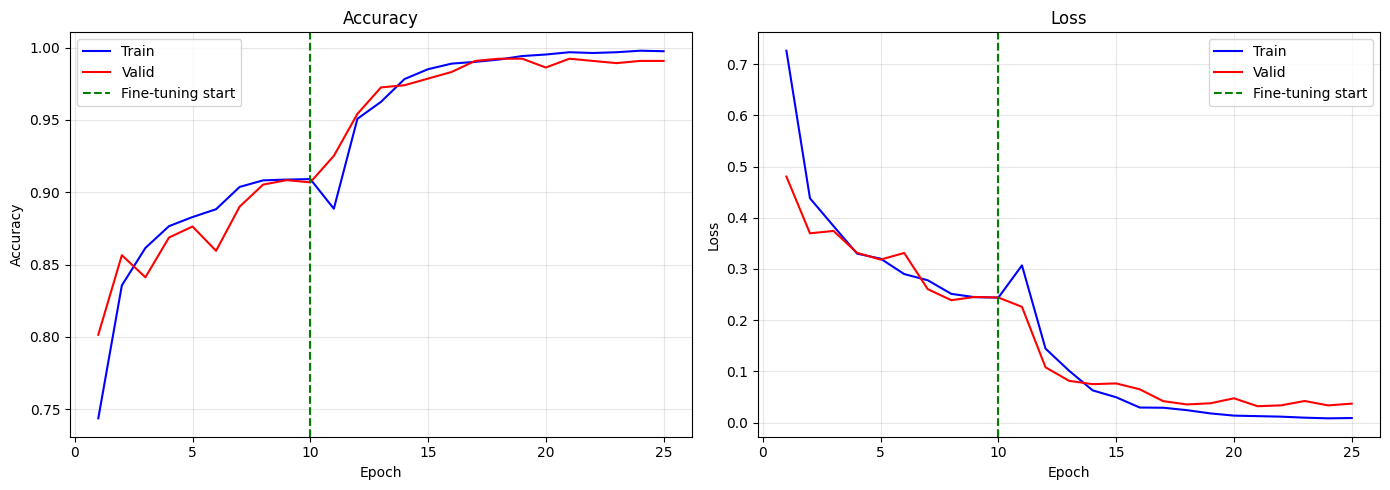

In [11]:
def plot_history(history1, history2):
    # Gom lich su
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(epochs, acc, 'b-', label='Train')
    axes[0].plot(epochs, val_acc, 'r-', label='Valid')
    axes[0].axvline(x=len(history1.history['accuracy']), color='g', linestyle='--', label='Fine-tuning start')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(epochs, loss, 'b-', label='Train')
    axes[1].plot(epochs, val_loss, 'r-', label='Valid')
    axes[1].axvline(x=len(history1.history['loss']), color='g', linestyle='--', label='Fine-tuning start')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_history(history1, history2)

Biểu đồ cho thấy bước nhảy vọt rõ rệt về độ chính xác (Accuracy) và giảm sâu về Loss ngay sau khi bỏ đóng băng (epoch 10). Điều này khẳng định chiến lược Fine-tuning là cực kỳ hiệu quả.

Chỉ với 25 epochs tổng cộng, Xception đã đạt hiệu năng tương đương (hoặc hơn) so với CNN tự xây (cần 70 epochs), tiết kiệm đáng kể thời gian huấn luyện.

Đường Train và Valid bám sát nhau ở giai đoạn cuối, cho thấy mô hình không bị Overfitting.

## 5. Evaluation

In [12]:
# Load best model
model = tf.keras.models.load_model('best_model_final.keras')

# Danh gia tren test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 828ms/step - accuracy: 0.9966 - loss: 0.0176

Test Accuracy: 99.70%
Test Loss: 0.0216


Xception có Test Loss cực thấp (0.0216)

xác suất dự đoán cho lớp đúng thường tiệm cận 1.0

In [13]:
# Du doan
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = [class_names.index(label) for label in test_df['label'].values]

# Classification Report
print('Classification Report:')
print('='*60)
print(classification_report(y_true, y_pred, target_names=class_names))

21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 690ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       150
  meningioma       0.99      1.00      0.99       153
     notumor       1.00      1.00      1.00       203
   pituitary       1.00      0.99      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



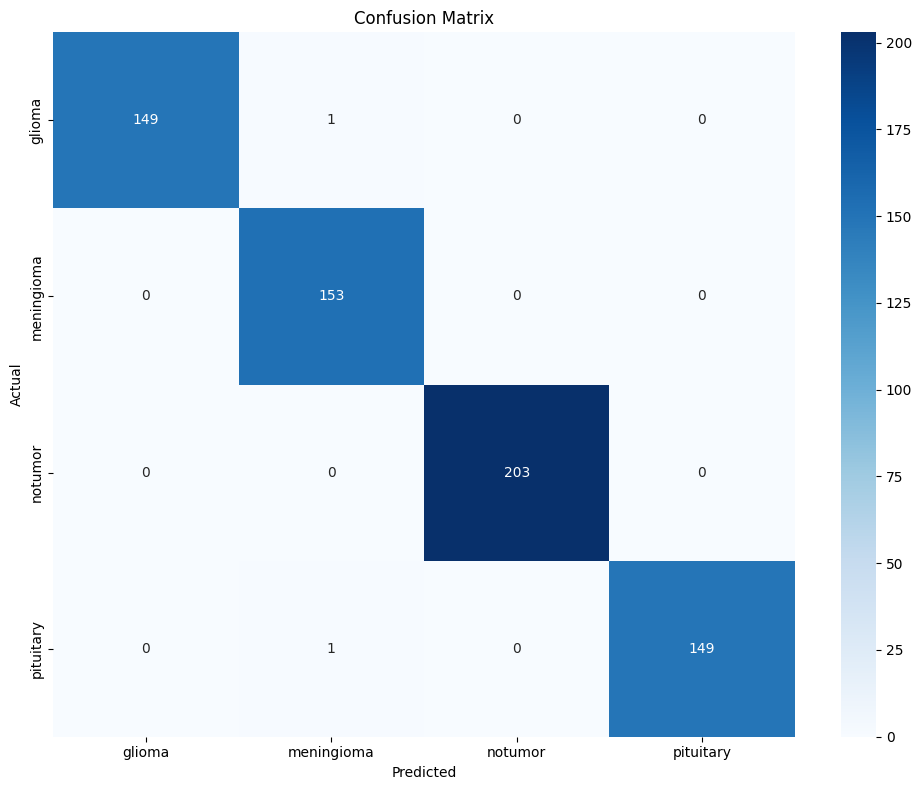

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 6. Sample Predictions

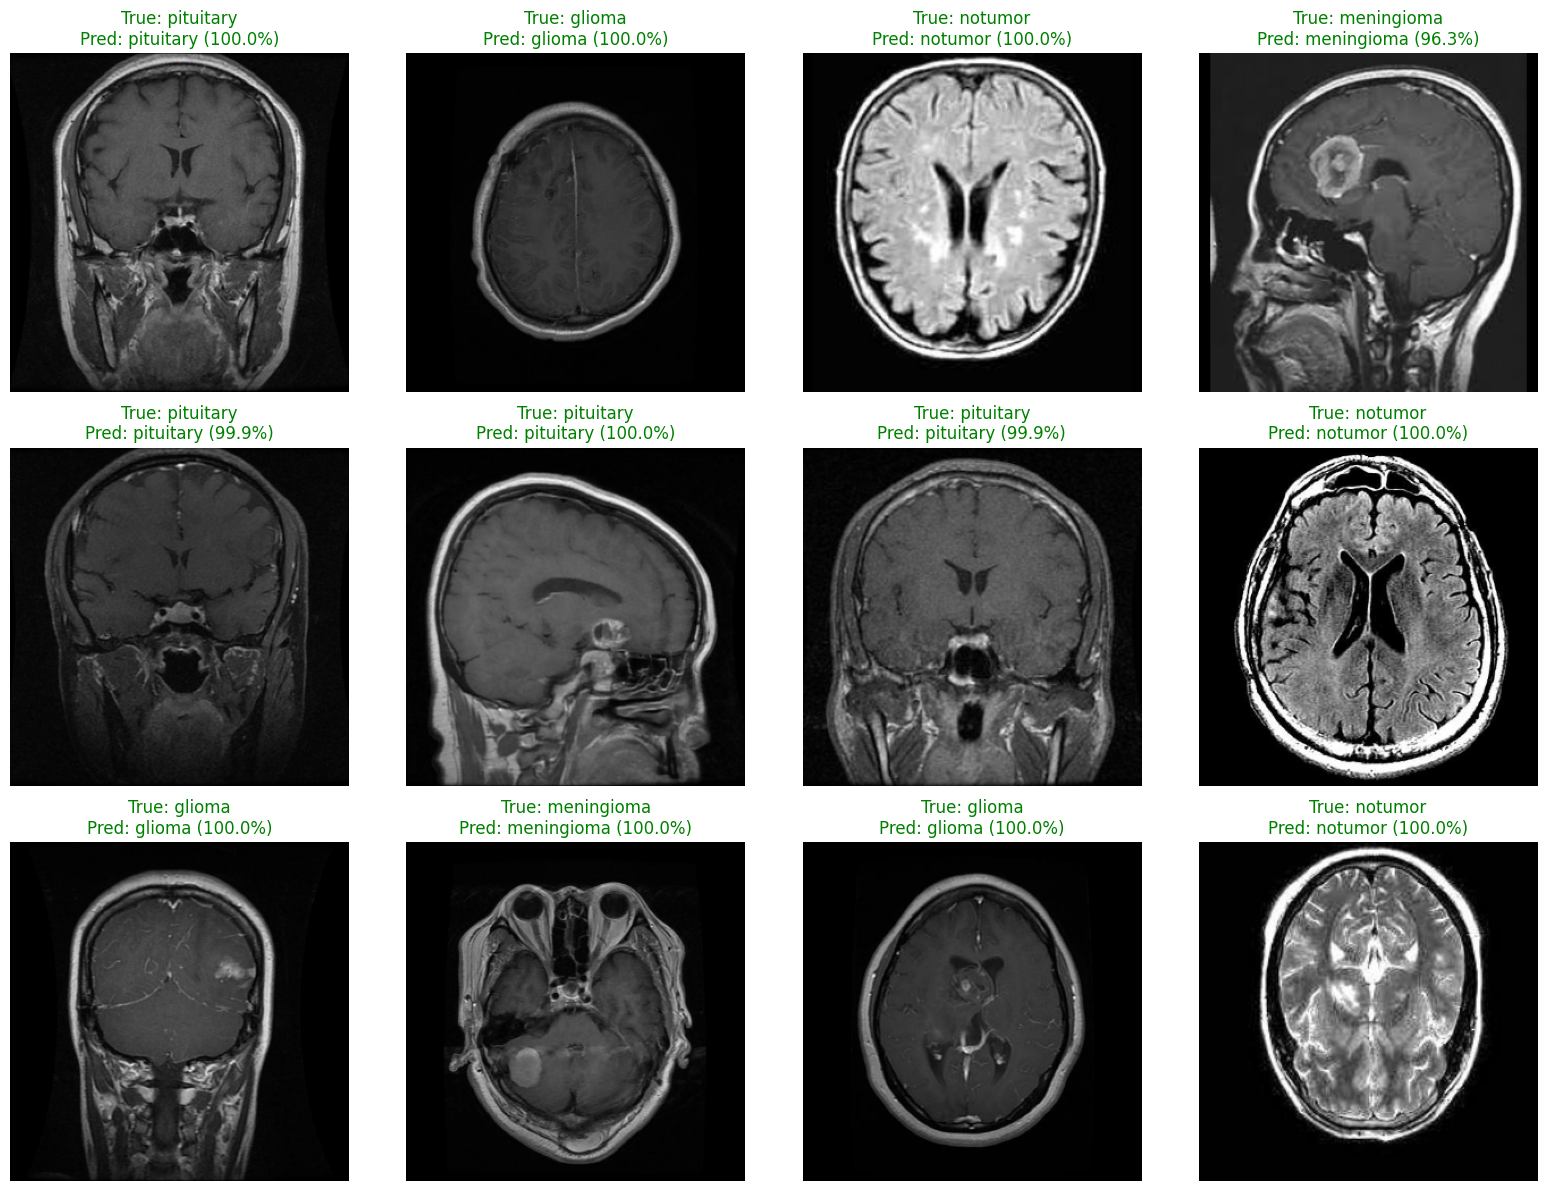

In [15]:
# Hien thi mot so du doan mau
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Lay mau tu test set
samples = test_df.sample(12)

for ax, (_, row) in zip(axes, samples.iterrows()):
    # Doc va xu ly anh
    img = cv2.imread(row['filepath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = resize_with_padding(img, IMG_SIZE)
    img_array = preprocess_image(img_display)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Du doan
    pred = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    
    # Hien thi
    ax.imshow(img_display)
    color = 'green' if pred_class == row['label'] else 'red'
    ax.set_title(f'True: {row["label"]}\nPred: {pred_class} ({confidence:.1f}%)', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 7. Save Model

In [16]:
# Luu model cuoi cung
model.save('brain_tumor_xception_final.keras')
print('Model saved successfully!')

Model saved successfully!


## 8. Grad-CAM Visualization

Grad-CAM (Gradient-weighted Class Activation Mapping) giúp trực quan hóa vùng ảnh mà model tập trung để đưa ra quyết định phân loại.

In [17]:
# ============================================================================
# 8. GRAD-CAM - TOÀN BỘ TẬP TEST (Fixed Version + Debug)
# ============================================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Tạo Grad-CAM Model một lần (hiệu quả hơn) ---
def get_grad_model(model):
    """Tạo Grad-CAM model một lần để tái sử dụng."""
    xception = [l for l in model.layers if 'xception' in l.name.lower()][0]
    conv_layer = [l for l in xception.layers if 'conv' in l.name.lower()][-1]
    grad_model = tf.keras.Model(xception.input, [conv_layer.output, xception.output])
    print(f"Grad-CAM layer: {conv_layer.name}")
    return grad_model

def generate_gradcam(model, grad_model, img_array):
    """Tạo Grad-CAM heatmap."""
    with tf.GradientTape() as tape:
        img_tensor = tf.cast(img_array, tf.float32)
        conv_out, pool_out = grad_model(img_tensor)
        tape.watch(conv_out)
        
        # Forward qua Dense layers
        x = pool_out
        for l in model.layers:
            if 'dense' in l.name or 'dropout' in l.name:
                x = l(x, training=False)
        
        # Lấy class được dự đoán
        pred_index = tf.argmax(x[0])
        loss = x[:, pred_index]
    
    grads = tape.gradient(loss, conv_out)
    
    if grads is None:
        return np.zeros((10, 10), dtype=np.float32)

    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(conv_out[0] * weights, axis=-1)
    
    # ReLU + Normalize
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap = heatmap / max_val
    
    return heatmap.numpy()

def save_gradcam_all(model, test_df, class_names, output_dir='gradcam_output'):
    """Lưu Grad-CAM cho toàn bộ tập test."""
    # Tạo Grad-CAM model một lần
    print("Building Grad-CAM model...")
    grad_model = get_grad_model(model)
    
    # Tạo folders
    for cls in class_names:
        os.makedirs(f'{output_dir}/{cls}', exist_ok=True)
    
    print(f'Processing {len(test_df)} images...')
    
    # Theo dõi các ảnh có vấn đề
    problem_images = []
    
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        try:
            filepath = row['filepath']
            filename = os.path.basename(filepath)
            true_label = row['label']
            
            # Load ảnh gốc
            original_img = cv2.imread(filepath)
            if original_img is None:
                continue
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            
            # Preprocess (giống training)
            processed_img = preprocess_image(resize_with_padding(original_img, (299, 299)))
            img_batch = processed_img[np.newaxis, ...]
            
            # DEBUG: Kiểm tra prediction
            preds = model.predict(img_batch, verbose=0)
            pred_class = class_names[np.argmax(preds[0])]
            confidence = np.max(preds[0]) * 100
            
            if pred_class != true_label or confidence < 50:
                problem_images.append({
                    'file': filename,
                    'true': true_label,
                    'pred': pred_class,
                    'conf': confidence
                })
            
            # Tạo heatmap
            heatmap = generate_gradcam(model, grad_model, img_batch)
            
            # Resize heatmap về kích thước ảnh gốc
            hm_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
            
            # Áp dụng colormap JET
            jet_heatmap = (plt.cm.jet(hm_resized)[:, :, :3] * 255).astype(np.uint8)
            
            # Overlay
            overlay = cv2.addWeighted(original_img, 0.6, jet_heatmap, 0.4, 0)
            
            # Lưu
            save_path = f"{output_dir}/{true_label}/{filename}"
            cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            
        except Exception as e:
            print(f"Error: {filepath} - {e}")

    # In kết quả
    print(f'\n{"="*60}')
    print(f'Done! Saved to: {output_dir}/')
    for cls in class_names:
        count = len(os.listdir(f'{output_dir}/{cls}'))
        print(f'   - {cls}: {count} images')
# --- Chạy ---
save_gradcam_all(model, test_df, class_names, output_dir='gradcam_output')

Building Grad-CAM model...
Grad-CAM layer: block14_sepconv2_act
Processing 656 images...


100%|██████████| 656/656 [03:32<00:00,  3.09it/s]


Done! Saved to: gradcam_output/
   - glioma: 150 images
   - meningioma: 153 images
   - notumor: 203 images
   - pituitary: 150 images


Grad-CAM model created!


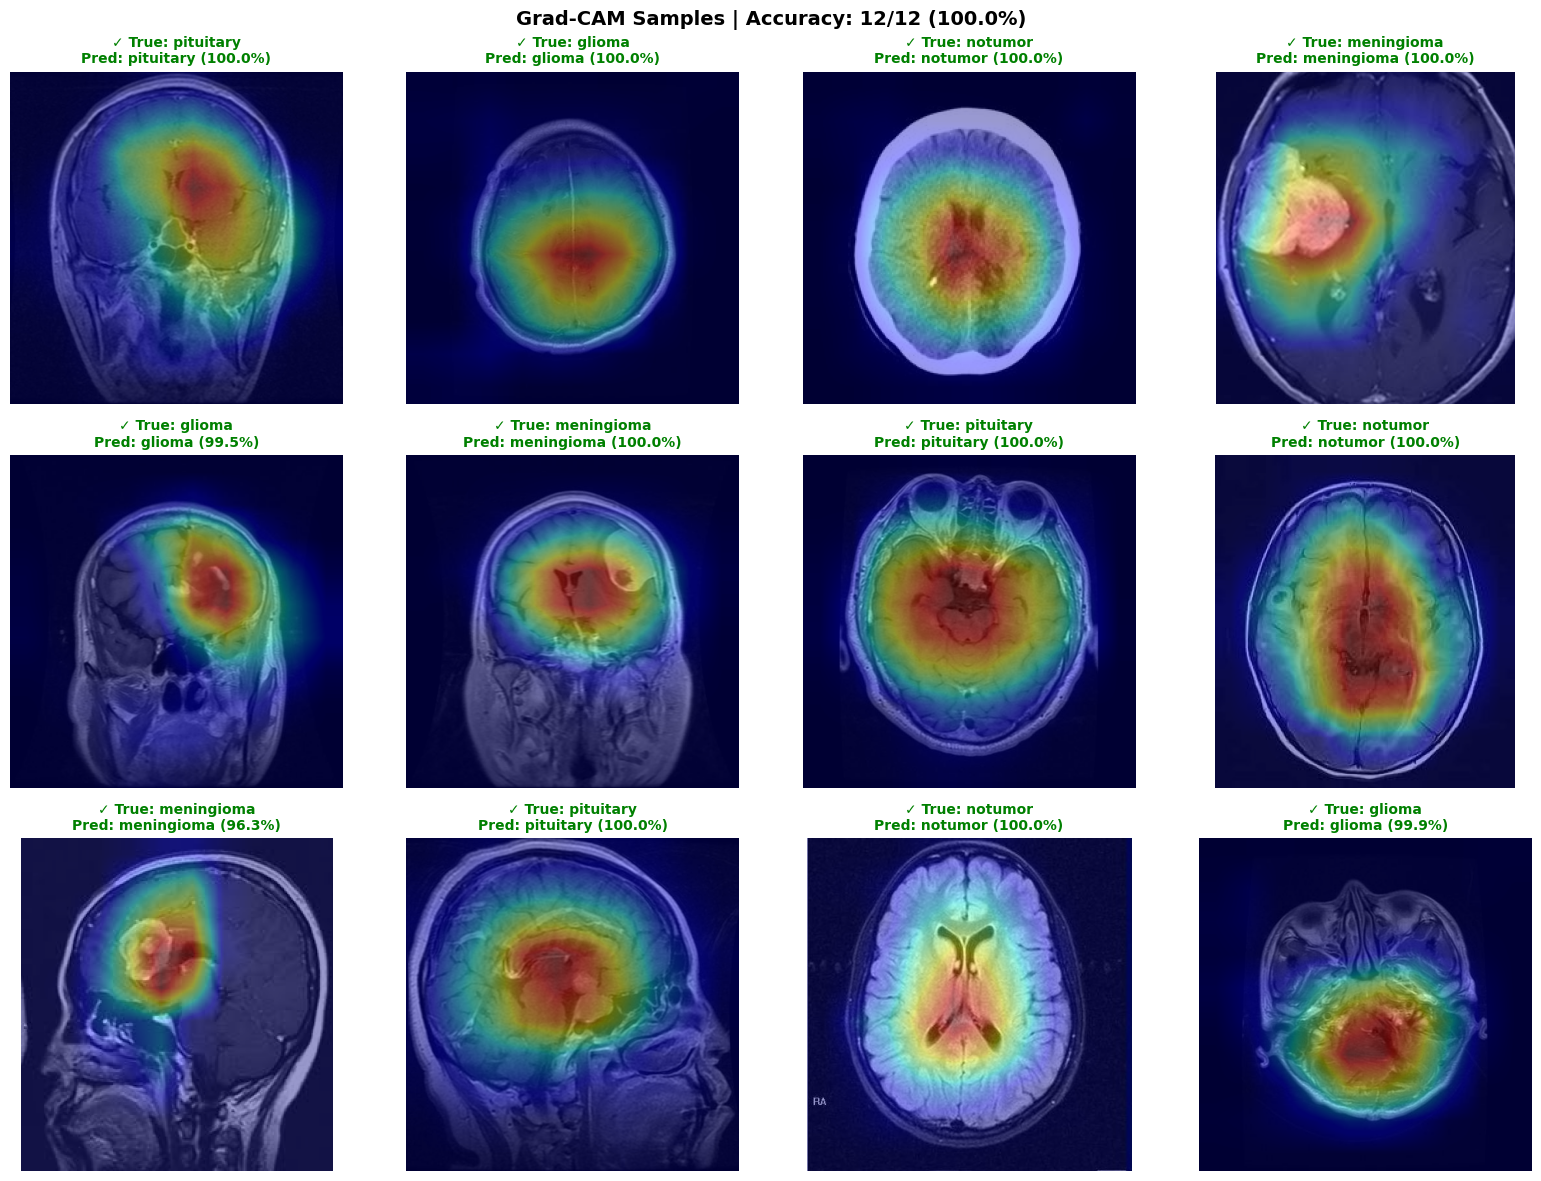


Sample Accuracy: 12/12 (100.0%)


In [18]:
# ============================================================================
# HIỂN THỊ MẪU GRAD-CAM + KIỂM TRA ĐỘ CHÍNH XÁC (Fixed)
# ============================================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Tạo Grad-CAM Model ---
def get_grad_model(model):
    """Tạo Grad-CAM model một lần để tái sử dụng."""
    xception = [l for l in model.layers if 'xception' in l.name.lower()][0]
    conv_layer = [l for l in xception.layers if 'conv' in l.name.lower()][-1]
    grad_model = tf.keras.Model(xception.input, [conv_layer.output, xception.output])
    return grad_model

def generate_gradcam(model, grad_model, img_array):
    """Tạo Grad-CAM heatmap."""
    with tf.GradientTape() as tape:
        img_tensor = tf.cast(img_array, tf.float32)
        conv_out, pool_out = grad_model(img_tensor)
        tape.watch(conv_out)
        
        x = pool_out
        for l in model.layers:
            if 'dense' in l.name or 'dropout' in l.name:
                x = l(x, training=False)
        
        pred_index = tf.argmax(x[0])
        loss = x[:, pred_index]
    
    grads = tape.gradient(loss, conv_out)
    
    if grads is None:
        return np.zeros((10, 10), dtype=np.float32)

    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(conv_out[0] * weights, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap = heatmap / max_val
    
    return heatmap.numpy()

# Tạo grad_model một lần
grad_model = get_grad_model(model)
print(f"Grad-CAM model created!")

def show_gradcam_samples(model, grad_model, test_df, class_names, n_samples=12):
    """Hiển thị mẫu Grad-CAM với thông tin dự đoán."""
    samples = test_df.sample(n=n_samples, random_state=42)
    
    cols = 4
    rows = (n_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten()
    
    correct = 0
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        # Load và xử lý
        img = cv2.cvtColor(cv2.imread(row['filepath']), cv2.COLOR_BGR2RGB)
        x = preprocess_image(resize_with_padding(img, (299, 299)))[np.newaxis, ...]
        
        # Predict
        preds = model.predict(x, verbose=0)[0]
        pred_idx = np.argmax(preds)
        pred_label = class_names[pred_idx]
        true_label = row['label']
        confidence = preds[pred_idx] * 100
        
        is_correct = pred_label == true_label
        if is_correct:
            correct += 1
        
        # Grad-CAM (SỬA: thêm grad_model)
        heatmap = generate_gradcam(model, grad_model, x)
        hm_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        jet_heatmap = (plt.cm.jet(hm_resized)[:, :, :3] * 255).astype(np.uint8)
        overlay = cv2.addWeighted(img, 0.6, jet_heatmap, 0.4, 0)
        
        # Plot
        axes[idx].imshow(overlay)
        axes[idx].axis('off')
        
        status = '✓' if is_correct else '✗'
        color = 'green' if is_correct else 'red'
        axes[idx].set_title(
            f'{status} True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
            fontsize=10, color=color, fontweight='bold'
        )
    
    # Ẩn axes thừa
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    accuracy = correct / n_samples * 100
    plt.suptitle(f'Grad-CAM Samples | Accuracy: {correct}/{n_samples} ({accuracy:.1f}%)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    os.makedirs('gradcam_output', exist_ok=True)
    plt.savefig('gradcam_output/samples_preview.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'\nSample Accuracy: {correct}/{n_samples} ({accuracy:.1f}%)')

# Hiển thị 12 mẫu (SỬA: thêm grad_model)
show_gradcam_samples(model, grad_model, test_df, class_names, n_samples=12)